In [28]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [29]:
import numpy as np
import scipy as sp
import sklearn as sk
import cartopy as cp
import xarray as xr
import pandas as pd
import cftime
import dateutil
import dask
#Use the 2 lines below if the notebook has a dark theme (to make labelling visible):
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)
import matplotlib.pyplot as plt
#The following code resets the default plot size so you don't have to fiddle with figsize every time"
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

In [30]:
#Need the following line to avoid hdf5 issues that prevent opening thee file
# https://stackoverflow.com/questions/49317927/errno-101-netcdf-hdf-error-when-opening-netcdf-file
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [31]:
from netCDF4 import Dataset
from datetime import datetime, timedelta
from netCDF4 import num2date, date2num

In [32]:
dataset_file = "pALLIN.nc"
airi_dat = xr.open_dataset(dataset_file, decode_times=False)
units, reference_date = airi_dat.time.attrs['units'].split('since')
airi_dat['time'] = pd.date_range(start=reference_date, periods=airi_dat.sizes['time'], freq='MS')

In [33]:
precip = airi_dat['precip']

In [34]:
#Load MSE data
mse_dat = xr.open_dataset('/global/scratch/medhap02/ISMData/ERAint_MSE_950.nc')
mse_dat = mse_dat.rename({'G4_LON_2':'lon', 'G4_LAT_1':'lat','MONTHAX':'time'})
mse = mse_dat['MSE']
print(mse_dat)

<xarray.Dataset>
Dimensions:             (LV_ISBL035_35: 1, bnds: 2, lat: 256, lon: 512, time: 456)
Coordinates:
  * lon                 (lon) float32 0.0 0.70312524 ... 358.59387 359.297
  * lat                 (lat) float32 -89.46282 -88.76695 ... 88.76695 89.46282
  * LV_ISBL035_35       (LV_ISBL035_35) int32 950
  * time                (time) datetime64[ns] 1979-01-16T12:00:00 ... 2016-12-16T12:00:00
Dimensions without coordinates: bnds
Data variables:
    G4_LON_2_bnds       (lon, bnds) float32 ...
    G4_LAT_1_bnds       (lat, bnds) float32 ...
    LV_ISBL035_35_bnds  (LV_ISBL035_35, bnds) int32 ...
    MONTHAX_bnds        (time, bnds) datetime64[ns] ...
    MSE                 (time, LV_ISBL035_35, lat, lon) float64 ...
Attributes:
    history:      PyFerret V7.43 (optimized) 26-Jun-20
    Conventions:  CF-1.6


In [35]:
#Slice MSE data to the same duration as precip and calculate monthly anomalies
mse_subset = mse.sel(time=slice('1979-01-01','2017-01-01'))
mse_clim = mse_subset.groupby('time.month').mean('time')
mse_anomfull = mse_subset.groupby("time.month")-mse_clim
mse_anomfull

<xarray.DataArray 'MSE' (time: 456, LV_ISBL035_35: 1, lat: 256, lon: 512)>
array([[[[ 791.919371, ...,  792.369689],
         ...,
         [-523.322914, ..., -518.583267]]],


       ...,


       [[[ 712.803134, ...,  711.92057 ],
         ...,
         [3524.112481, ..., 3522.678587]]]])
Coordinates:
  * lon            (lon) float32 0.0 0.70312524 1.4062505 ... 358.59387 359.297
  * lat            (lat) float32 -89.46282 -88.76695 ... 88.76695 89.46282
  * LV_ISBL035_35  (LV_ISBL035_35) int32 950
  * time           (time) datetime64[ns] 1979-01-16T12:00:00 ... 2016-12-16T12:00:00
    month          (time) int64 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

In [36]:
mse_subset16 = mse_anomfull.sel(time=slice('1979-01-01','1979-12-31'))
mse_subset17 = mse_anomfull.sel(time=slice('1981-01-01','1982-12-31'))
mse_subset18 = mse_anomfull.sel(time=slice('1984-01-01','1991-12-31'))
mse_subset19 = mse_anomfull.sel(time=slice('1993-01-01','1998-12-31'))
mse_subset20 = mse_anomfull.sel(time=slice('2000-01-01','2002-12-31'))
mse_subset21 = mse_anomfull.sel(time=slice('2004-01-01','2006-12-31'))
mse_subset22 = mse_anomfull.sel(time=slice('2008-01-01','2010-12-31'))
mse_subset23 = mse_anomfull.sel(time=slice('2012-01-01','2015-12-31'))

mse_anomtemp = xr.merge([mse_subset16, mse_subset17, mse_subset18, mse_subset19, mse_subset20, 
                   mse_subset21, mse_subset22, mse_subset23])
print(mse_anomtemp)
mse_anom = mse_anomtemp['MSE']

<xarray.Dataset>
Dimensions:        (LV_ISBL035_35: 1, lat: 256, lon: 512, time: 360)
Coordinates:
  * time           (time) datetime64[ns] 1979-01-16T12:00:00 ... 2015-12-16T12:00:00
  * lon            (lon) float32 0.0 0.70312524 1.4062505 ... 358.59387 359.297
  * lat            (lat) float32 -89.46282 -88.76695 ... 88.76695 89.46282
  * LV_ISBL035_35  (LV_ISBL035_35) int32 950
    month          (time) float64 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
Data variables:
    MSE            (time, LV_ISBL035_35, lat, lon) float64 791.9 ... -1.019e+03


In [37]:
#Get precip anomalies
precip_clim = precip.groupby("time.month").mean("time")
precip_anomfull = precip.groupby("time.month") - precip_clim

In [38]:
precip_subset16 = precip_anomfull.sel(time=slice('1979-01-01','1979-12-31'))
precip_subset17 = precip_anomfull.sel(time=slice('1981-01-01','1982-12-31'))
precip_subset18 = precip_anomfull.sel(time=slice('1984-01-01','1991-12-31'))
precip_subset19 = precip_anomfull.sel(time=slice('1993-01-01','1998-12-31'))
precip_subset20 = precip_anomfull.sel(time=slice('2000-01-01','2002-12-31'))
precip_subset21 = precip_anomfull.sel(time=slice('2004-01-01','2006-12-31'))
precip_subset22 = precip_anomfull.sel(time=slice('2008-01-01','2010-12-31'))
precip_subset23 = precip_anomfull.sel(time=slice('2012-01-01','2015-12-31'))

precip_anom = xr.merge([precip_subset16, precip_subset17, precip_subset18, precip_subset19, precip_subset20, 
                   precip_subset21, precip_subset22, precip_subset23])
precip_anomtemp = xr.Dataset.to_array(precip_anom)
precip_anom = precip_anom['precip']
print(precip_anom)

<xarray.DataArray 'precip' (time: 360)>
array([ 11.233562,   3.835616,  14.854794, ..., -44.439735, -40.930824,
        13.444523], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2015-12-01
    month    (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 8.0 9.0 10.0 11.0 12.0


In [39]:
junes = np.arange(5,360,12)
julys = np.arange(6,360,12)
augusts = np.arange(7,360, 12)
septembers = np.arange(8,360,12)
precipa_june = precip_anom[junes]
precipa_july = precip_anom[julys]
precipa_august = precip_anom[augusts]
precipa_september = precip_anom[septembers]

precipa_july.time.data = precipa_june.time.data
precipa_august.time.data = precipa_june.time.data
precipa_september.time.data = precipa_june.time.data

precipa_jjas = (precipa_june + precipa_july + precipa_august + precipa_september)

In [40]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

In [41]:
#(10-25n, 75-105e)

latrange = mse_anom.sel(lat = slice(10, 25)).lat
weights1 = np.cos(latrange*np.pi/180)

marchdata1 = mse_anom.sel(lat = slice(10, 25), lon = slice(75, 105), time = (mse_anom['time.month']==3))
marchMSE1 = marchdata1.sel(time = slice('1979-03-01', '2015-03-30'))
marchmean1 = (marchMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

aprildata1 = mse_anom.sel(lat = slice(10, 25), lon = slice(75, 105), time = (mse_anom['time.month']==4))
aprilMSE1 = aprildata1.sel(time = slice('1979-04-01', '2015-04-30'))
aprilmean1 = (aprilMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = mse_anom.sel(lat = slice(10, 25), lon = slice(75, 105), time = (mse_anom['time.month']==5))
mayMSE1 = maydata1.sel(time = slice('1979-05-01', '2015-05-30'))
maymean1 = (mayMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

marchmean1.time.data = maymean1.time.data
aprilmean1.time.data = maymean1.time.data

MSEmamtemp = (marchmean1 + aprilmean1 + maymean1)/3

MSEmam = MSEmamtemp
MSEstd = MSEmam.std()
MSEmean = MSEmam.mean()
MSEmam = (MSEmam - MSEmean)/MSEstd
print(MSEmam)

<xarray.DataArray (time: 30, LV_ISBL035_35: 1)>
array([[-0.505353],
       [-1.07088 ],
       [-0.658925],
       [-0.495106],
       [ 0.048917],
       [-0.896647],
       [-1.61928 ],
       [ 1.419703],
       [-1.759806],
       [ 0.612754],
       [ 1.833469],
       [-1.233793],
       [ 0.159935],
       [-0.081196],
       [ 0.055624],
       [-2.149836],
       [ 1.570492],
       [-0.002945],
       [ 0.583238],
       [ 0.097338],
       [ 0.67176 ],
       [ 0.164995],
       [ 0.673533],
       [-0.294477],
       [ 0.282004],
       [ 2.094978],
       [ 0.086488],
       [-0.01181 ],
       [-0.515589],
       [ 0.940415]])
Coordinates:
  * time           (time) datetime64[ns] 1979-05-16T12:00:00 ... 2015-05-16T12:00:00
  * LV_ISBL035_35  (LV_ISBL035_35) int32 950
    month          (time) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0


In [42]:
#(0-25n, 45-70e)
#(20-40n, 70-90e)

latrange = mse_anom.sel(lat = slice(0, 25)).lat
weights = np.cos(latrange*np.pi/180)

marchdata1 = mse_anom.sel(lat = slice(0, 25), lon = slice(45, 70), time = (mse_anom['time.month']==3))
marchMSE1 = marchdata1.sel(time = slice('1979-03-01', '2015-03-30'))
marchmean1 = (marchMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

aprildata1 = mse_anom.sel(lat = slice(0, 25), lon = slice(45, 70), time = (mse_anom['time.month']==4))
aprilMSE1 = aprildata1.sel(time = slice('1979-04-01', '2015-04-30'))
aprilmean1 = (aprilMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = mse_anom.sel(lat = slice(0, 25), lon = slice(45, 70), time = (mse_anom['time.month']==5))
mayMSE1 = maydata1.sel(time = slice('1979-05-01', '2015-05-30'))
maymean1 = (mayMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

marchmean1.time.data = maymean1.time.data
aprilmean1.time.data = maymean1.time.data

MSEwest = maymean1 - marchmean1

latrange2 = mse_anom.sel(lat = slice(20, 40)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = mse_anom.sel(lat = slice(20, 40), lon = slice(70, 90), time = (mse_anom['time.month']==3))
marchMSE2 = marchdata2.sel(time = slice('1979-03-01', '2015-03-30'))
marchmean2 = ((marchMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

aprildata2 = mse_anom.sel(lat = slice(20, 40), lon = slice(70, 90), time = (mse_anom['time.month']==4))
aprilMSE2 = aprildata2.sel(time = slice('1979-04-01', '2015-04-30'))
aprilmean2 = ((aprilMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

maydata2 = mse_anom.sel(lat = slice(20, 40), lon = slice(70, 90), time = (mse_anom['time.month']==5))
mayMSE2 = maydata2.sel(time = slice('1979-05-01', '2015-05-30'))
maymean2 = ((mayMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

marchmean2.time.data = maymean2.time.data
aprilmean2.time.data = maymean2.time.data

MSEeast = maymean2 - marchmean2

#MSEeast.time.data = MSEwest.time.data

MSEmay_mar = (MSEeast + MSEwest)/2
print(MSEmay_mar)
MSEstd = MSEmay_mar.std()
MSEmean = MSEmay_mar.mean()
MSEmay_mar = (MSEmay_mar - MSEmean)/MSEstd
print(MSEmay_mar)

<xarray.DataArray (time: 30, LV_ISBL035_35: 1)>
array([[ -632.354751],
       [ -972.244131],
       [-1645.796739],
       [   82.160024],
       [ -298.548346],
       [ -243.899724],
       [-3150.871889],
       [ -419.741397],
       [-3013.223347],
       [ 2536.389581],
       [-1508.194668],
       [ 1569.076007],
       [  -11.333617],
       [-2456.074401],
       [-3301.519255],
       [-3357.507971],
       [  841.511468],
       [ 6067.429492],
       [ 2657.642041],
       [  532.790832],
       [  250.324195],
       [-2720.231621],
       [ 1636.701108],
       [ 3117.932991],
       [-1333.12824 ],
       [ 1185.76948 ],
       [ 2603.021379],
       [ -924.350028],
       [ -457.162953],
       [  -93.596685]])
Coordinates:
  * time           (time) datetime64[ns] 1979-05-16T12:00:00 ... 2015-05-16T12:00:00
  * LV_ISBL035_35  (LV_ISBL035_35) int32 950
<xarray.DataArray (time: 30, LV_ISBL035_35: 1)>
array([[-0.240962],
       [-0.399361],
       [-0.713257],
       [ 0

In [43]:
precipa_jjas.time.data = maymean1.time.data

msemam = correlation(MSEmam, precipa_jjas, dims='time')
print("MSE mam", msemam.data)
msemamtemp = correlation(MSEmamtemp, precipa_jjas, dims='time')
print("Non standardized MSE MAM", msemamtemp.data)

print()
msemay_mar = correlation(MSEmay_mar, precipa_jjas, dims='time')
print("MSE May - March 2 boxes", msemay_mar.data)
mseeast = correlation(MSEeast, precipa_jjas, dims='time')
print("MSE Right", mseeast.data)
msewest = correlation(MSEwest, precipa_jjas, dims='time')
print("MSE Left", msewest.data)

MSE mam [0.24463817]
Non standardized MSE MAM [0.24463817]

MSE May - March 2 boxes [0.1979125]
MSE Right [0.216085]
MSE Left [0.10656084]


In [44]:
from cartopy import config
import cartopy.crs as ccrs

from matplotlib import pyplot
import matplotlib.patches as mpatches

In [45]:
mse_anomalt = mse_anom.squeeze('LV_ISBL035_35')

march = np.arange(2,360,12)
april = np.arange(3,360,12)
may = np.arange(4,360,12)

msea_march = mse_anomalt[march,:,:]
msea_april = mse_anomalt[april,:,:]
msea_may = mse_anomalt[may,:,:]

msea_march.time.data = msea_may.time.data
msea_april.time.data = msea_may.time.data

precipa_june = precip_anom[junes]
precipa_july = precip_anom[julys]
precipa_august = precip_anom[augusts]
precipa_september = precip_anom[septembers]

precipa_july.time.data = precipa_june.time.data
precipa_august.time.data = precipa_june.time.data
precipa_september.time.data = precipa_june.time.data

precipa_jjas = precipa_june + precipa_july + precipa_august + precipa_september

msea_mam = msea_march + msea_april + msea_may
msea_may_mar = msea_may - msea_march

precipa_jjas.time.data = msea_mam.time.data

Text(0.5, 1.0, 'Correlation Between MarchAprilMay MSEA and JJAS AIRI Anomalies')

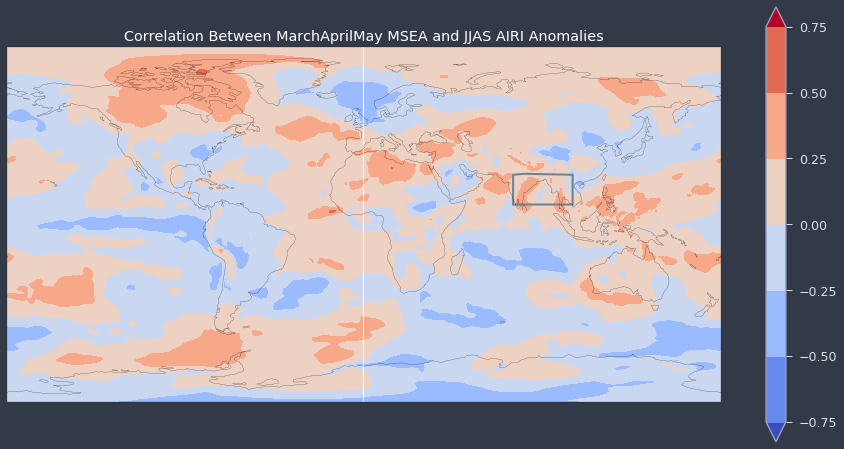

In [46]:
mse_mam_r = correlation(msea_mam,precipa_jjas,dims='time')
ax = plt.axes(projection=ccrs.PlateCarree())
mse_mam_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[75,10], width=30, height=15, facecolor=None, edgecolor='slategray', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#(10-25n, 75-105e)
plt.title('Correlation Between MarchAprilMay MSEA and JJAS AIRI Anomalies', color = 'white')

Text(0.5, 1.0, 'Correlation Between May-March MSEA and JJAS AIRI Anomalies')

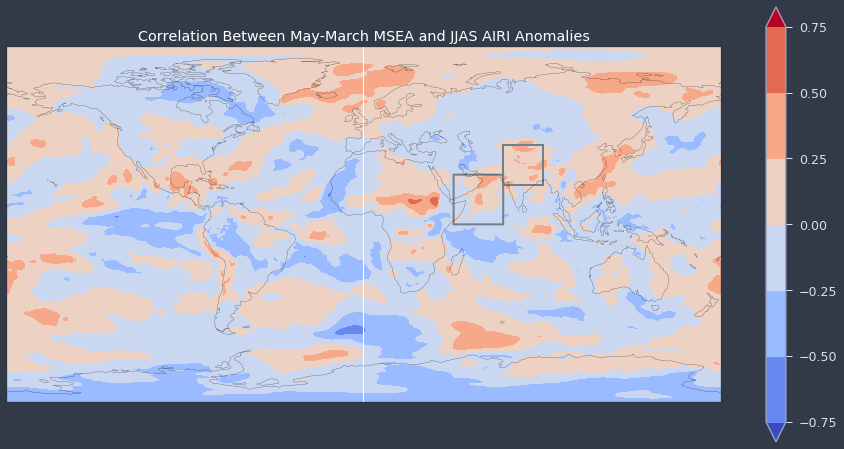

In [47]:
mse_may_mar_r = correlation(msea_may_mar,precipa_jjas,dims='time')
ax = plt.axes(projection=ccrs.PlateCarree())
mse_may_mar_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[45,0], width=25, height=25, facecolor=None, edgecolor='slategray', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#(0-25n, 45-70e)
ax.add_patch(mpatches.Rectangle(xy=[70,20], width=20, height=20, facecolor=None, edgecolor='slategray', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#(20-40n, 70-90e)
plt.title('Correlation Between May-March MSEA and JJAS AIRI Anomalies', color = 'white')

# New MSE Dataset

In [93]:
mse_dat = xr.open_dataset('/global/scratch/medhap02/ISMData/MSE.sig995.mon.mean.jan1948sep2012.nc')
mse = mse_dat['__xarray_dataarray_variable__']
mse

<xarray.DataArray '__xarray_dataarray_variable__' (time: 777, lat: 73, lon: 144)>
[8167824 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2012-09-01

In [94]:
#Slice MSE data to the same duration as precip and calculate monthly anomalies
mse_subset = mse.sel(time=slice('1948-01-01','2013-01-01'))
mse_clim = mse_subset.groupby('time.month').mean('time')
mse_anomfull = mse_subset.groupby("time.month")-mse_clim
mse_anomfull

<xarray.DataArray '__xarray_dataarray_variable__' (time: 777, lat: 73, lon: 144)>
array([[[-4558.5156 , -4558.5156 , ..., -4558.5156 , -4558.5156 ],
        [-3787.3281 , -3817.4844 , ..., -3736.6562 , -3756.7031 ],
        ...,
        [ 5260.7188 ,  5271.625  , ...,  5210.2812 ,  5238.5938 ],
        [ 5433.7188 ,  5433.7188 , ...,  5433.7188 ,  5433.7188 ]],

       [[-2197.3125 , -2197.3125 , ..., -2197.3125 , -2197.3125 ],
        [-2745.8438 , -2623.2969 , ..., -2995.5625 , -2876.3281 ],
        ...,
        [ 1059.8438 ,  1027.     , ...,  1102.7812 ,  1080.2188 ],
        [ 2270.5625 ,  2270.5625 , ...,  2270.5625 ,  2270.5625 ]],

       ...,

       [[ 1076.8125 ,  1076.8125 , ...,  1076.8125 ,  1076.8125 ],
        [  421.4375 ,   449.625  , ...,   351.40625,   377.71875],
        ...,
        [ 3067.9844 ,  3230.5156 , ...,  2745.1719 ,  2907.75   ],
        [ 4140.7188 ,  4140.7188 , ...,  4140.7188 ,  4140.7188 ]],

       [[ 6621.6875 ,  6621.6875 , ...,  6621.6875 ,  66

In [95]:
mse_subset10 = mse_anomfull.sel(time=slice('1948-01-01','1948-12-31'))
mse_subset11 = mse_anomfull.sel(time=slice('1951-01-01','1955-12-31'))
mse_subset12 = mse_anomfull.sel(time=slice('1957-01-01','1958-12-31'))
mse_subset13 = mse_anomfull.sel(time=slice('1960-01-01','1962-12-31'))
mse_subset13 = mse_anomfull.sel(time=slice('1964-01-01','1965-12-31'))
mse_subset14 = mse_anomfull.sel(time=slice('1967-01-01','1971-12-31'))
mse_subset15 = mse_anomfull.sel(time=slice('1973-01-01','1976-12-31'))
mse_subset16 = mse_anomfull.sel(time=slice('1978-01-01','1979-12-31'))
mse_subset17 = mse_anomfull.sel(time=slice('1981-01-01','1982-12-31'))
mse_subset18 = mse_anomfull.sel(time=slice('1984-01-01','1991-12-31'))
mse_subset19 = mse_anomfull.sel(time=slice('1993-01-01','1998-12-31'))
mse_subset20 = mse_anomfull.sel(time=slice('2000-01-01','2002-12-31'))
mse_subset21 = mse_anomfull.sel(time=slice('2004-01-01','2006-12-31'))
mse_subset22 = mse_anomfull.sel(time=slice('2008-01-01','2010-12-31'))
mse_subset23 = mse_anomfull.sel(time=slice('2012-01-01','2013-12-31'))

mse_anomtemp = xr.merge([mse_subset10, mse_subset11, mse_subset12, mse_subset13, mse_subset14, 
                         mse_subset15, mse_subset16, mse_subset17, mse_subset18, mse_subset19, 
                         mse_subset20, mse_subset21, mse_subset22, mse_subset23])
#mse_anom = xr.Dataset.to_array(mse_anomtemp).drop('variable')
print(mse_anomtemp)
mse_anom = mse_anomtemp['__xarray_dataarray_variable__']
#1902, 1907, 1912, 1914, 1919, 1922, 1928, 1932, 1933, 1940
#1949, 1950, 1956, 1959, 1963, 1966, 1972, 1977, 1980, 1983
#1992, 1999, 2003, 2007, 2011

<xarray.Dataset>
Dimensions:                        (lat: 73, lon: 144, time: 561)
Coordinates:
  * time                           (time) datetime64[ns] 1948-01-01 ... 2012-09-01
  * lat                            (lat) float32 90.0 87.5 85.0 ... -87.5 -90.0
  * lon                            (lon) float32 0.0 2.5 5.0 ... 355.0 357.5
    month                          (time) float64 1.0 2.0 3.0 ... 7.0 8.0 9.0
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) float32 -4558.5156 ... 6342.453


In [96]:
#Get precip anomalies
precip_clim = precip.groupby("time.month").mean("time")
precip_anomfull = precip.groupby("time.month") - precip_clim

In [97]:
precip_subset10 = precip_anomfull.sel(time=slice('1948-01-01','1948-12-31'))
precip_subset11 = precip_anomfull.sel(time=slice('1951-01-01','1955-12-31'))
precip_subset12 = precip_anomfull.sel(time=slice('1957-01-01','1958-12-31'))
precip_subset13 = precip_anomfull.sel(time=slice('1960-01-01','1962-12-31'))
precip_subset13 = precip_anomfull.sel(time=slice('1964-01-01','1965-12-31'))
precip_subset14 = precip_anomfull.sel(time=slice('1967-01-01','1971-12-31'))
precip_subset15 = precip_anomfull.sel(time=slice('1973-01-01','1976-12-31'))
precip_subset16 = precip_anomfull.sel(time=slice('1978-01-01','1979-12-31'))
precip_subset17 = precip_anomfull.sel(time=slice('1981-01-01','1982-12-31'))
precip_subset18 = precip_anomfull.sel(time=slice('1984-01-01','1991-12-31'))
precip_subset19 = precip_anomfull.sel(time=slice('1993-01-01','1998-12-31'))
precip_subset20 = precip_anomfull.sel(time=slice('2000-01-01','2002-12-31'))
precip_subset21 = precip_anomfull.sel(time=slice('2004-01-01','2006-12-31'))
precip_subset22 = precip_anomfull.sel(time=slice('2008-01-01','2010-12-31'))
precip_subset23 = precip_anomfull.sel(time=slice('2012-01-01','2012-12-31'))

precip_anom = xr.merge([precip_subset10, precip_subset11, precip_subset12, precip_subset13, precip_subset14, 
                        precip_subset15, precip_subset16, precip_subset17, precip_subset18, precip_subset19, 
                        precip_subset20, precip_subset21, precip_subset22, precip_subset23])
precip_anomtemp = xr.Dataset.to_array(precip_anom)
precip_anom = precip_anom['precip']
print(precip_anom)
#1902, 1907, 1912, 1914, 1919, 1922, 1928, 1932, 1933, 1940
#1949, 1950, 1956, 1959, 1963, 1966, 1972, 1977, 1980, 1983
#1992, 1999, 2003, 2007, 2011

<xarray.DataArray 'precip' (time: 564)>
array([  7.633561,  14.635615,   1.654795, ...,  12.460266, -12.530823,
         3.544525], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2012-12-01
    month    (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 8.0 9.0 10.0 11.0 12.0


In [98]:
junes = np.arange(5,564,12)
julys = np.arange(6,564,12)
augusts = np.arange(7,564, 12)
septembers = np.arange(8,564,12)
precipa_june = precip_anom[junes]
precipa_july = precip_anom[julys]
precipa_august = precip_anom[augusts]
precipa_september = precip_anom[septembers]

precipa_july.time.data = precipa_june.time.data
precipa_august.time.data = precipa_june.time.data
precipa_september.time.data = precipa_june.time.data

precipa_jjas = (precipa_june + precipa_july + precipa_august + precipa_september)

In [99]:
#(10-25n, 75-105e)

latrange = mse_anom.sel(lat = slice(25, 10)).lat
weights1 = np.cos(latrange*np.pi/180)

marchdata1 = mse_anom.sel(lat = slice(25, 10), lon = slice(75, 105), time = (mse_anom['time.month']==3))
marchMSE1 = marchdata1.sel(time = slice('1948-03-01', '2013-03-01'))
marchmean1 = (marchMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

aprildata1 = mse_anom.sel(lat = slice(25, 10), lon = slice(75, 105), time = (mse_anom['time.month']==4))
aprilMSE1 = aprildata1.sel(time = slice('1948-04-01', '2013-04-01'))
aprilmean1 = (aprilMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = mse_anom.sel(lat = slice(25, 10), lon = slice(75, 105), time = (mse_anom['time.month']==5))
mayMSE1 = maydata1.sel(time = slice('1948-05-01', '2013-05-01'))
maymean1 = (mayMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

marchmean1.time.data = maymean1.time.data
aprilmean1.time.data = maymean1.time.data

MSEmamtemp = (marchmean1 + aprilmean1 + maymean1)/3

MSEmam = MSEmamtemp
MSEstd = MSEmam.std()
MSEmean = MSEmam.mean()
MSEmam = (MSEmam - MSEmean)/MSEstd
print(MSEmam)

<xarray.DataArray (time: 47)>
array([-1.410619, -1.351592, -0.017683,  0.142134, -0.114628, -0.796479,
        0.372486,  2.618104,  0.12017 , -1.548683, -1.291113, -1.317659,
        0.946894,  0.721912, -1.220846,  0.89001 , -1.234622, -1.003928,
       -1.62199 , -0.440776, -0.68564 ,  0.553638, -0.343344, -0.102053,
        0.542443, -0.081049,  0.004818,  1.488562, -1.094906,  0.707149,
        0.980229, -1.18185 , -0.009116, -0.500004, -0.099849, -0.927602,
        1.466038,  0.155684,  0.90263 , -0.228449,  0.64554 ,  0.758366,
        1.198821,  0.173025,  0.547325,  2.492481,  0.196021], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1948-05-01 1951-05-01 ... 2012-05-01
    month    (time) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0


In [100]:
#(0-25n, 45-70e)
#(20-40n, 70-90e)

latrange = mse_anom.sel(lat = slice(25, 0)).lat
weights = np.cos(latrange*np.pi/180)

marchdata1 = mse_anom.sel(lat = slice(25, 0), lon = slice(45, 70), time = (mse_anom['time.month']==3))
marchMSE1 = marchdata1.sel(time = slice('1948-03-01', '2013-03-01'))
marchmean1 = (marchMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

aprildata1 = mse_anom.sel(lat = slice(25, 0), lon = slice(45, 70), time = (mse_anom['time.month']==4))
aprilMSE1 = aprildata1.sel(time = slice('1948-04-01', '2013-04-01'))
aprilmean1 = (aprilMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = mse_anom.sel(lat = slice(25, 0), lon = slice(45, 70), time = (mse_anom['time.month']==5))
mayMSE1 = maydata1.sel(time = slice('1948-05-01', '2013-05-01'))
maymean1 = (mayMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

marchmean1.time.data = maymean1.time.data
aprilmean1.time.data = maymean1.time.data

MSEleft = maymean1 - marchmean1

latrange2 = mse_anom.sel(lat = slice(40, 20)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = mse_anom.sel(lat = slice(40, 20), lon = slice(70, 90), time = (mse_anom['time.month']==3))
marchMSE2 = marchdata2.sel(time = slice('1948-03-01', '2013-03-01'))
marchmean2 = ((marchMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

aprildata2 = mse_anom.sel(lat = slice(40, 20), lon = slice(70, 90), time = (mse_anom['time.month']==4))
aprilMSE2 = aprildata2.sel(time = slice('1948-04-01', '2013-04-01'))
aprilmean2 = ((aprilMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

maydata2 = mse_anom.sel(lat = slice(40, 20), lon = slice(70, 90), time = (mse_anom['time.month']==5))
mayMSE2 = maydata2.sel(time = slice('1948-05-01', '2013-05-01'))
maymean2 = ((mayMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

marchmean2.time.data = maymean2.time.data
aprilmean2.time.data = maymean2.time.data

MSEright = maymean2 - marchmean2

MSEmay_mar = (MSEright + MSEleft)/2
print(MSEmay_mar)
MSEstd = MSEmay_mar.std()
MSEmean = MSEmay_mar.mean()
MSEmay_mar = (MSEmay_mar - MSEmean)/MSEstd
print(MSEmay_mar)

<xarray.DataArray (time: 47)>
array([  -52.0838  ,  -385.25793 ,   532.3849  , -1292.2667  ,  -308.7552  ,
       -2834.688   ,   657.6694  , -2023.8923  , -2484.409   ,  -329.16577 ,
       -2476.2646  , -2072.9868  , -3884.1287  ,  1500.6093  ,   889.6415  ,
        2157.3066  , -1742.1353  ,  1460.832   , -1337.272   ,  2836.2314  ,
          95.77646 ,  -169.82007 ,  -478.94608 , -1228.3617  ,  -799.4554  ,
         232.22382 , -2537.187   ,  1852.7686  ,  -528.43335 ,  4171.604   ,
         -64.84733 ,  2820.2864  ,  -552.1559  ,  -416.47363 , -3527.2744  ,
       -2337.5583  ,  2524.4585  ,  4779.4873  ,  2359.0562  ,  -125.372406,
       -1505.9929  , -3755.9258  ,  1870.2327  ,  1820.6833  ,  -294.69916 ,
         468.70837 ,  2871.8486  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1948-05-01 1951-05-01 ... 2012-05-01
<xarray.DataArray (time: 47)>
array([ 0.012595, -0.1523  ,  0.30186 , -0.601197, -0.114437, -1.364573,
        0.363866, -0.963294, -1.191213

In [101]:
precipa_jjas.time.data = maymean1.time.data

In [102]:
msemam = correlation(MSEmam, precipa_jjas, dims='time')
print("MSE mam", msemam.data)
msemamtemp = correlation(MSEmamtemp, precipa_jjas, dims='time')
print("Non standardized MSE MAM", msemamtemp.data)

print()
msemay_mar = correlation(MSEmay_mar, precipa_jjas, dims='time')
print("MSE May - March 2 boxes", msemay_mar.data)
mseeast = correlation(MSEright, precipa_jjas, dims='time')
print("MSE Right", mseeast.data)
msewest = correlation(MSEleft, precipa_jjas, dims='time')
print("MSE Left", msewest.data)

MSE mam 0.1987505202979531
Non standardized MSE MAM 0.19875054748614432

MSE May - March 2 boxes 0.26275207978038573
MSE Right 0.2559595914983956
MSE Left 0.209084676367546


In [103]:
#(45-70n, 95e-150w)

latrange = mse_anom.sel(lat = slice(70, 45)).lat
weights1 = np.cos(latrange*np.pi/180)

marchdata1 = mse_anom.sel(lat = slice(70, 45), lon = slice(95, 210), time = (mse_anom['time.month']==3))
marchMSE1 = marchdata1.sel(time = slice('1900-03-01', '2015-03-01'))
marchmean1 = (marchMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = mse_anom.sel(lat = slice(70, 45), lon = slice(95, 210), time = (mse_anom['time.month']==5))
mayMSE1 = maydata1.sel(time = slice('1900-05-01', '2015-05-01'))
maymean1 = (mayMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

marchmean1.time.data = maymean1.time.data

MSErussiainitial = maymean1 - marchmean1

MSErussia = MSErussiainitial
MSEstd = MSErussia.std()
MSEmean = MSErussia.mean()
MSErussia = (MSErussia - MSEmean)/MSEstd
print(MSErussia)

<xarray.DataArray (time: 47)>
array([-0.352767,  1.101403, -0.107318, -0.129071, -0.19556 ,  1.078184,
        1.443411, -0.238663,  0.338249, -1.429032,  0.66665 , -1.744275,
        0.368787,  1.137134,  0.921999, -0.271512, -0.089446, -0.296537,
       -0.132445, -1.054493,  0.673145,  0.721328, -0.194714,  0.918531,
        0.806318, -0.181519, -0.555568,  0.945851, -1.80681 , -1.401483,
        0.822915, -1.113667,  0.741873, -0.473513, -0.36295 , -0.579051,
       -1.587511, -0.192542,  0.052407, -0.877428, -0.165677, -0.55472 ,
       -0.486404, -1.852016,  0.542707,  2.768373,  2.377426], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1948-05-01 1951-05-01 ... 2012-05-01


In [104]:
mserussia = correlation(MSErussia, precipa_jjas, dims='time')
print("MSE may - march Russia", mserussia.data)
mserussiainitial = correlation(MSErussiainitial, precipa_jjas, dims='time')
print("Non standardized MSE May-March Russia", mserussiainitial.data)

print()
msecorrmamrussia = correlation(MSEmam, MSErussia, dims='time')
print("Correlation between MSE MAM box and May-March Russia", msecorrmamrussia.data)

# the 2 boxes have a -.27 correlation w/ EQ india so might not want to use
msecorrmay_mar2boxesrussia = correlation(MSEmay_mar, MSErussia, dims='time')
print("Correlation between MSE May-March 2 boxes and Russia", msecorrmay_mar2boxesrussia.data)

MSE may - march Russia 0.07935930993961436
Non standardized MSE May-March Russia 0.07935929357428571

Correlation between MSE MAM box and May-March Russia 0.26500322463664605
Correlation between MSE May-March 2 boxes and Russia -0.06115193934407786


In [105]:
MSEmamrussia = (MSEmamtemp + MSErussia)/2 #bin wang never mixes up the months when doing combine predictors
MSEstd = MSEmamrussia.std()
MSEmean = MSEmamrussia.mean()
MSEmamrussia = (MSEmamrussia - MSEmean)/MSEstd

msemamnrussia = correlation(MSEmamrussia, precipa_jjas, dims='time')
print("MAM box and May-March Russia mean", msemamnrussia.data)
print()
print("Following Values Aren't Standardized")
print("MAM Box", msemamtemp.data)
print("Russia Box", mserussiainitial.data)

MAM box and May-March Russia mean 0.1987730487553896

Following Values Aren't Standardized
MAM Box 0.19875054748614432
Russia Box 0.07935929357428571


In [106]:
MSEmay_marmean = (MSEright + MSEleft + MSErussiainitial)/3
MSEstd = MSEmay_marmean.std()
MSEmean = MSEmay_marmean.mean()
MSEmay_marmean = (MSEmay_marmean - MSEmean)/MSEstd

msemay_mar3boxes = correlation(MSEmay_marmean, precipa_jjas, dims='time')
print("All 3 boxes in May-March mean", msemay_mar3boxes.data)
print()
print("Following Values Aren't Standardized")
print("Left Box", msewest.data)
print("Right Box", mseeast.data)
print("Russia Box", mserussiainitial.data)

All 3 boxes in May-March mean 0.27955575132377364

Following Values Aren't Standardized
Left Box 0.209084676367546
Right Box 0.2559595914983956
Russia Box 0.07935929357428571


In [107]:
mse_anomalt = mse_anom

march = np.arange(2,564,12)
april = np.arange(3,564,12)
may = np.arange(4,564,12)

msea_march = mse_anomalt[march,:,:]
msea_april = mse_anomalt[april,:,:]
msea_may = mse_anomalt[may,:,:]

msea_march.time.data = msea_may.time.data
msea_april.time.data = msea_may.time.data

precipa_june = precip_anom[junes]
precipa_july = precip_anom[julys]
precipa_august = precip_anom[augusts]
precipa_september = precip_anom[septembers]

precipa_july.time.data = precipa_june.time.data
precipa_august.time.data = precipa_june.time.data
precipa_september.time.data = precipa_june.time.data

precip_jjas = precipa_june + precipa_july + precipa_august + precipa_september

msea_mam = msea_march + msea_april + msea_may
msea_may_mar = msea_may - msea_march

precip_jjas.time.data = msea_mam.time.data

In [108]:
mse_mam_r = correlation(msea_mam,precip_jjas,dims='time')
mse_may_mar_r = correlation(msea_may_mar,precip_jjas,dims='time')

Text(0.5, 1.0, 'Correlation Between MarchAprilMay MSEA and JJAS AIRI Anomalies')

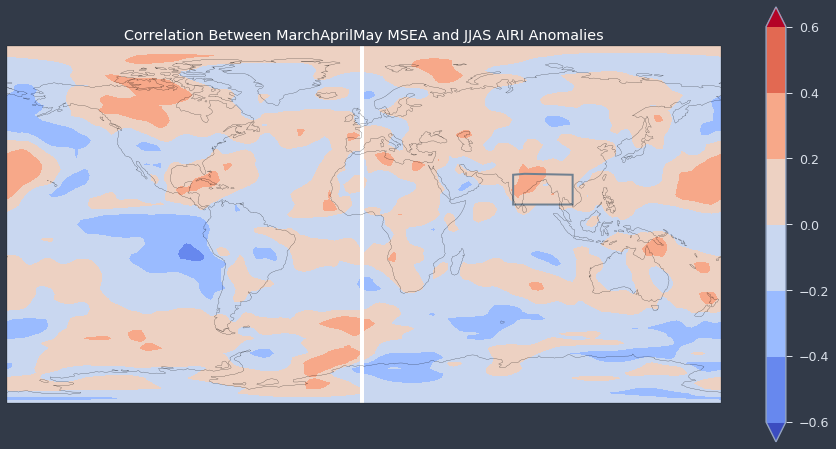

In [109]:
ax = plt.axes(projection=ccrs.PlateCarree())
mse_mam_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[75,10], width=30, height=15, facecolor=None, edgecolor='slategray', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#(10-25n, 75-105e)
plt.title('Correlation Between MarchAprilMay MSEA and JJAS AIRI Anomalies', color = 'white')

Text(0.5, 1.0, 'Correlation Between May-March MSEA and JJAS AIRI Anomalies')

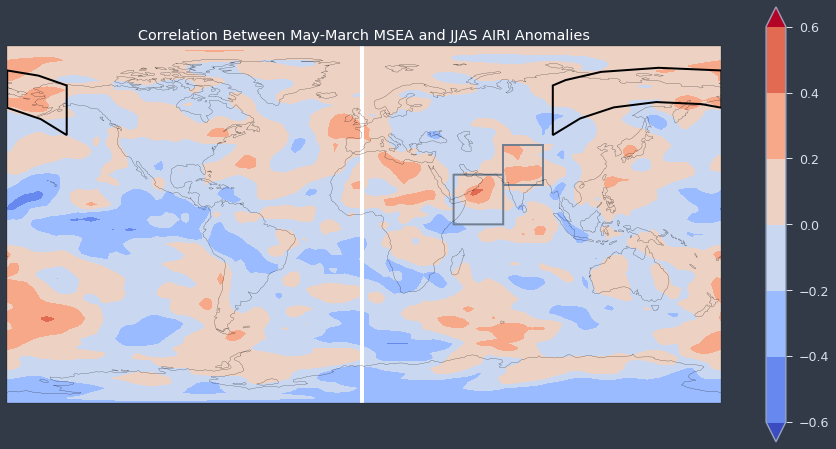

In [110]:
ax = plt.axes(projection=ccrs.PlateCarree())
mse_may_mar_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[45,0], width=25, height=25, facecolor=None, edgecolor='slategray', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#(0-25n, 45-70e)
ax.add_patch(mpatches.Rectangle(xy=[70,20], width=20, height=20, facecolor=None, edgecolor='slategray', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#(20-40n, 70-90e)
ax.add_patch(mpatches.Rectangle(xy=[95,45], width=115, height=25, facecolor=None, edgecolor='black', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#(45-70n, 95e-150w)
plt.title('Correlation Between May-March MSEA and JJAS AIRI Anomalies', color = 'white')